In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
import json

In [2]:
# plotting settings
fm.fontManager.addfont('../references/cmunorm.ttf')
matplotlib.rcParams['font.family'] = 'CMU Concrete'
plt.rc('axes', unicode_minus=False)

## Data for QGIS DistanceCartogram transformations

In [136]:
# main data with places/dates
df = pd.read_csv('../data/processed_data.tsv', sep='\t', encoding='utf8', na_values=pd.NA).convert_dtypes()
df.doc_date = pd.to_datetime(df.doc_date)
df['doc_year'] = df.doc_date.dt.year
df.origin_date = pd.to_datetime(df.origin_date)
df = df[df.delta.isin(range(0,100))]

In [137]:
# coordinates
places = pd.read_csv('../data/places/places_new.tsv', sep='\t', encoding='utf8', index_col='Unnamed: 0')
#places['freq'] = [len(main_df[main_df.placename==name]) for name in places.placename]

In [5]:
# average times for all locations by year
#delta = pd.read_csv('../data/places/average_times.tsv', sep='\t', encoding='utf8', index_col='Unnamed: 0', na_values=pd.NA)

In [138]:
delta = df.groupby(['doc_year', 'placename'])['delta'].mean().unstack()

In [139]:
# GeoPandas DataFrame from the coordinates
gdf_base = gpd.GeoDataFrame(places, geometry=gpd.points_from_xy(places.longitude, places.latitude), crs='EPSG:4326')
gdf_base.to_crs(crs='ESRI:102014', inplace=True) # projection used for my visualisations

In [140]:
# extract Riga for point of reference
riga = gdf_base.loc[gdf_base.placename=='Riga', 'geometry'].values[0]
gdf_base['distance_to_riga'] = np.round(gdf_base.geometry.distance(riga)/1000).astype(int)

In [13]:
#with open('../data/places/distance_to_riga.json', 'w', encoding='utf8') as f:
#    json.dump(list(gdf_base.distance_to_riga), f)

transform points märge: võtta enne arvutusi kõigist kestustest 0,5 või 1 päev maha, trükkimist arvestades

In [141]:
# gets the most frequent places for given timerange, so the transformation maps are based on most complete data
def get_most_frequent_places(df, timerange, topn):
    
    return df.loc[df.doc_date.dt.year.isin(timerange)].placename.value_counts().index[:topn]


# takes in the coordinates of places and moves them according to the average movement time
def transform_points(gdf, main_df, timerange, topn, printing_delay=0, exclude=[], save=False):
    
    df = gdf.copy()
    
    # define riga and drop it from calculations
    riga = df.loc[df.placename=='Riga', 'geometry'].values[0]
    df.drop(df[df.placename == 'Riga'].index, inplace=True)
    # distances to riga in km from each location
    df['distance_to_riga'] = np.round(df.geometry.distance(riga)/1000).astype(int)
    
    # places that will be on the map
    places = [place for place in get_most_frequent_places(main_df, timerange, topn) if place not in exclude]
    placename_id_dict = dict(zip(places, range(len(places)))) # for adding numerical id column later
    
    start = timerange[0]
    stop = timerange[-1]
    
    # get the average movement speeds during the timerange
    means = delta.loc[start:stop].mean().dropna()[places]
    
    # generate a movement time column
    df['delta'] = df['placename'].apply(lambda x: means[x]-printing_delay if x in places else pd.NA) # printing_delay is subtracted from all the deltas
    df.dropna(subset='delta', inplace=True)
    
    # get occurrence counts for all placenames within the timerange
    df['freq'] = df.placename.apply(lambda name: len(main_df[main_df.doc_date.dt.year.isin(timerange) & (main_df.placename == name)]))
    
    # average speed for each location and across all locations
    df['avg_speed'] = df['distance_to_riga']/df['delta']
    total_avg_speed = df['avg_speed'].mean()
    
    # weighted distance = time * average movement speed across all locations
    df['distance_transformed'] = df['delta']*total_avg_speed
    
    # calculating the new coordinates
    df['PB'] = riga.y - df.geometry.y
    df['VB'] = riga.x - df.geometry.x
    df['V_B_'] = df['VB'] * df['distance_transformed'] / df['distance_to_riga']
    df['PB_'] = df['PB'] * df['distance_transformed'] / df['distance_to_riga']
    df['X_new'] = riga.x - df['V_B_']
    df['Y_new'] = riga.y - df['PB_']
    
    
    # create Dataframes for new coordinates (points_t) and old coordinates (with minimum necessary info, points)
    points_t = gpd.GeoDataFrame(data={'placename': df.placename, 'longitude': df['X_new'], 'latitude': df['Y_new'], 'freq': df['freq']},
                                geometry=gpd.points_from_xy(df['X_new'], df['Y_new']))
    points_t = points_t.append({'placename': 'Riga', 'longitude': riga.x, 'latitude': riga.y, 'geometry': riga}, ignore_index=True)
    points_t['id'] = points_t.placename.apply(lambda name: placename_id_dict[name])
    
    
    points = gpd.GeoDataFrame(data={'placename': df.placename, 'longitude': df.geometry.x, 'latitude': df.geometry.y, 'freq': df['freq']},
                               geometry=gpd.points_from_xy(df.geometry.x, df.geometry.y))
    points = points.append({'placename': 'Riga', 'longitude': riga.x, 'latitude': riga.y}, ignore_index=True)
    points['id'] = points.placename.apply(lambda name: placename_id_dict[name])
    
    
    if save:
        points_t.to_csv(f"../qgis/points_{start}_{stop}_transformed.tsv",
                        sep='\t', encoding='utf8')
        points.to_csv(f"../qgis/points_{start}_{stop}.tsv",
                      sep='\t', encoding='utf8')
    
    return points, points_t

In [142]:
transform_points(gdf=gdf_base,
                 main_df=df,
                 timerange=range(1802, 1860),
                 topn=100,
                 printing_delay=1,
                 save=True,
                 exclude=['New York', 'Türkische Grenze', 'Washington', 'Bombay'])

C:\Users\krister\AppData\Local\Temp\ipykernel_26944\1715850301.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points_t = points_t.append({'placename': 'Riga', 'longitude': riga.x, 'latitude': riga.y, 'geometry': riga}, ignore_index=True)
C:\Users\krister\py_projects\rz_acta\acta_env\lib\site-packages\pandas\core\dtypes\cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\krister\AppData\Local\Temp\ipykernel_26944\1715850301.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points = points.append({'placename': 'Riga', 'longitude': riga.x, 'latitude': riga.y}, ignore_index=True)


(         placename     longitude      latitude     freq  \
 0            Paris -5.539576e+05  2.155201e+06  14859.0   
 1           London -6.911593e+05  2.466065e+06  12612.0   
 2           Berlin  2.282959e+05  2.534201e+06   6494.0   
 3   St. Petersburg  1.114258e+06  3.503554e+06   7717.0   
 4             Wien  4.680385e+05  2.075517e+06   7748.0   
 ..             ...           ...           ...      ...   
 92          Toulon -3.309667e+05  1.502492e+06    196.0   
 93          Algier -6.302129e+05  8.065256e+05    258.0   
 94           Malta  4.104057e+05  6.961537e+05    182.0   
 95  Rio de Janeiro -1.058886e+07 -4.258924e+06    196.0   
 96            Riga  8.435574e+05  3.097649e+06      NaN   
 
                               geometry  id  
 0      POINT (-553957.620 2155200.805)   0  
 1      POINT (-691159.277 2466065.263)   1  
 2       POINT (228295.878 2534201.358)   4  
 3      POINT (1114257.517 3503553.863)   3  
 4       POINT (468038.471 2075517.256)   2  
 .

In [143]:
transform_points(gdf=gdf_base,
                 main_df=df,
                 timerange=range(1860, 1889),
                 topn=100,
                 printing_delay=0.5,
                 save=True,
                 exclude=['New York', 'Türkische Grenze', 'Washington', 'Bombay'])

C:\Users\krister\AppData\Local\Temp\ipykernel_26944\1715850301.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points_t = points_t.append({'placename': 'Riga', 'longitude': riga.x, 'latitude': riga.y, 'geometry': riga}, ignore_index=True)
C:\Users\krister\py_projects\rz_acta\acta_env\lib\site-packages\pandas\core\dtypes\cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\krister\AppData\Local\Temp\ipykernel_26944\1715850301.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points = points.append({'placename': 'Riga', 'longitude': riga.x, 'latitude': riga.y}, ignore_index=True)


(         placename     longitude      latitude     freq  \
 0            Paris -5.539576e+05  2.155201e+06  13309.0   
 1           London -6.911593e+05  2.466065e+06  10808.0   
 2           Berlin  2.282959e+05  2.534201e+06  16003.0   
 3   St. Petersburg  1.114258e+06  3.503554e+06  12866.0   
 4             Wien  4.680385e+05  2.075517e+06   8464.0   
 ..             ...           ...           ...      ...   
 92          Fellin  8.973323e+05  3.268620e+06    111.0   
 93          Mexiko -8.613799e+06  6.887147e+06     88.0   
 94        Shanghai  7.196202e+06  7.195405e+06    122.0   
 95          Wolmar  9.074579e+05  3.177929e+06     88.0   
 96            Riga  8.435574e+05  3.097649e+06      NaN   
 
                             geometry  id  
 0    POINT (-553957.620 2155200.805)   1  
 1    POINT (-691159.277 2466065.263)   3  
 2     POINT (228295.878 2534201.358)   0  
 3    POINT (1114257.517 3503553.863)   2  
 4     POINT (468038.471 2075517.256)   4  
 ..           

In [312]:
transform_points(gdf=gdf_base,
                 main_df=df,
                 timerange=range(1860, 1871),
                 topn=100,
                 printing_delay=0.5,
                 save=True,
                 exclude=['New York', 'Türkische Grenze', 'Washington', 'Bombay'])

C:\Users\krister\AppData\Local\Temp\ipykernel_26944\1715850301.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points_t = points_t.append({'placename': 'Riga', 'longitude': riga.x, 'latitude': riga.y, 'geometry': riga}, ignore_index=True)
C:\Users\krister\py_projects\rz_acta\acta_env\lib\site-packages\pandas\core\dtypes\cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\krister\AppData\Local\Temp\ipykernel_26944\1715850301.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points = points.append({'placename': 'Riga', 'longitude': riga.x, 'latitude': riga.y}, ignore_index=True)


(         placename     longitude      latitude    freq  \
 0            Paris -5.539576e+05  2.155201e+06  5001.0   
 1           London -6.911593e+05  2.466065e+06  4546.0   
 2           Berlin  2.282959e+05  2.534201e+06  4767.0   
 3   St. Petersburg  1.114258e+06  3.503554e+06  3444.0   
 4             Wien  4.680385e+05  2.075517e+06  3763.0   
 ..             ...           ...           ...     ...   
 92          Mexiko -8.613799e+06  6.887147e+06    75.0   
 93        Shanghai  7.196202e+06  7.195405e+06    88.0   
 94        Veracruz -8.618753e+06  6.527011e+06    80.0   
 95  Rio de Janeiro -1.058886e+07 -4.258924e+06    50.0   
 96            Riga  8.435574e+05  3.097649e+06     NaN   
 
                               geometry  id  
 0      POINT (-553957.620 2155200.805)   0  
 1      POINT (-691159.277 2466065.263)   2  
 2       POINT (228295.878 2534201.358)   1  
 3      POINT (1114257.517 3503553.863)   4  
 4       POINT (468038.471 2075517.256)   3  
 ..           

In [257]:
gdf_base

,placename,latitude,longitude,calendar,total_freq,german_presence,russian_empire,sovereign_capital,geometry,distance_to_riga
0,Paris,48.85341,2.34880,g,25539,0.0,0.0,1.0,POINT (-553957.620 2155200.805),1686
1,London,51.50853,-0.12574,g,21172,0.0,0.0,1.0,POINT (-691159.277 2466065.263),1660
2,Berlin,52.52437,13.41053,g,18077,1.0,0.0,1.0,POINT (228295.878 2534201.358),834
3,St. Petersburg,59.93863,30.31413,j,17770,0.0,1.0,1.0,POINT (1114257.517 3503553.863),488
4,Wien,48.20849,16.37208,g,14724,1.0,0.0,1.0,POINT (468038.471 2075517.256),1089
...,...,...,...,...,...,...,...,...,...,...
319,Brest,48.39029,-4.48628,g,20,NaN,NaN,NaN,POINT (-1053976.778 2181334.703),2107
343,Santander,43.46472,-3.80444,g,20,NaN,NaN,NaN,POINT (-1108794.124 1637695.043),2438
328,Osnabrück,52.27264,8.04980,g,20,NaN,NaN,NaN,POINT (-131202.866 2502940.084),1142
341,Pskow,57.81360,28.34960,j,20,NaN,NaN,NaN,POINT (1068291.858 3247315.246),270


4.7

In [326]:
delta.loc[1870:1875, 'London']

doc_year
1870    4.569395
1871    4.374603
1872    3.593156
1873    3.248082
1874    3.045534
1875    2.836401
Name: London, dtype: Float64

In [325]:
delta.loc[1861:1889].mean()[['Moskau', 'St. Petersburg', 'Konstantinopel', 'Stockholm', 'Berlin', 'London', 'Paris', 'Rom',
              'Reval', 'Dorpat', 'Libau', 'Pernau', 'Madrid', 'Odessa']].sort_values()

placename
St. Petersburg      2.5802
Berlin            2.929227
London            3.700505
Paris             3.879235
Madrid            4.283561
Libau             4.719711
Dorpat            4.910665
Reval             5.212165
Pernau            5.440961
Konstantinopel    5.899234
Stockholm         6.002817
Moskau            6.081025
Rom               6.246038
Odessa            7.345493
dtype: object

In [297]:
def get_avg_speed(place, timerange):
    
    dist = gdf_base.loc[gdf_base.placename==place, 'distance_to_riga'].values[0]
    time = delta.loc[timerange[0]:timerange[-1], place].mean()
        
    return round(dist/time)

In [311]:
for place in ['Moskau', 'St. Petersburg', 'Konstantinopel', 'Stockholm', 'Berlin', 'London', 'Paris', 'Rom',
              'Reval', 'Dorpat', 'Libau', 'Pernau', 'Reval', 'Madrid', 'Odessa']:
    print(f'Average speed from {place}: {get_avg_speed(place, range(1802,1860))} km/d')

Average speed from Moskau: 41 km/d
Average speed from St. Petersburg: 52 km/d
Average speed from Konstantinopel: 48 km/d
Average speed from Stockholm: 21 km/d
Average speed from Berlin: 69 km/d
Average speed from London: 99 km/d
Average speed from Paris: 106 km/d
Average speed from Rom: 69 km/d
Average speed from Reval: 17 km/d
Average speed from Dorpat: 20 km/d
Average speed from Libau: 20 km/d
Average speed from Pernau: 15 km/d
Average speed from Reval: 17 km/d
Average speed from Madrid: 106 km/d
Average speed from Odessa: 46 km/d


In [308]:
get_avg_speed('Konstantinopel', range(1802,1889))

66

In [300]:
get_avg_speed('St. Petersburg', range(1802,1860))

52

## Maps of Europe and the world

In [27]:
def plot_europe(gdf, land, min_freq, savepath=None):    
    
    fig, ax = plt.subplots(figsize=(15,15))
    
    land.boundary.plot(ax=ax, color='grey')
    
    gdf.plot(ax=ax, markersize=gdf['total_freq']/10, edgecolor='red', facecolor=(1, 0, 0.2, 0.1))

    for x, y, freq, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.total_freq, gdf.placename):
        if freq > min_freq:
            if x > 1560320:
                ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", ha='right', fontsize=14)
            elif label in ['Versailles', 'Karlsruhe', 'Darmstadt', 'Odessa']:
                ax.annotate(label, xy=(x, y-50000), xytext=(3, 3), textcoords="offset points", ha='right', fontsize=14)
            else:
                ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=14)
        #elif freq < min_freq and freq > min_freq/2:
        #    if x > 1560320:
        #        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", ha='right', fontsize=10)
        #    else:
        #        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=10)

    ax.set_xlim(-1771030.9557765622, 1771059.394568238)
    ax.set_ylim(-83913.47395288725, 3977831.559172161)
    #ax.set_xlim(-30, 70)
    #ax.set_ylim(20,70)

    plt.xticks([])
    plt.yticks([])
    
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
        
    plt.show()

In [19]:
# import world map
land = gpd.read_file('../qgis/shapefiles/ne_50m_land.zip')
land.to_crs(crs='ESRI:102014', inplace=True)

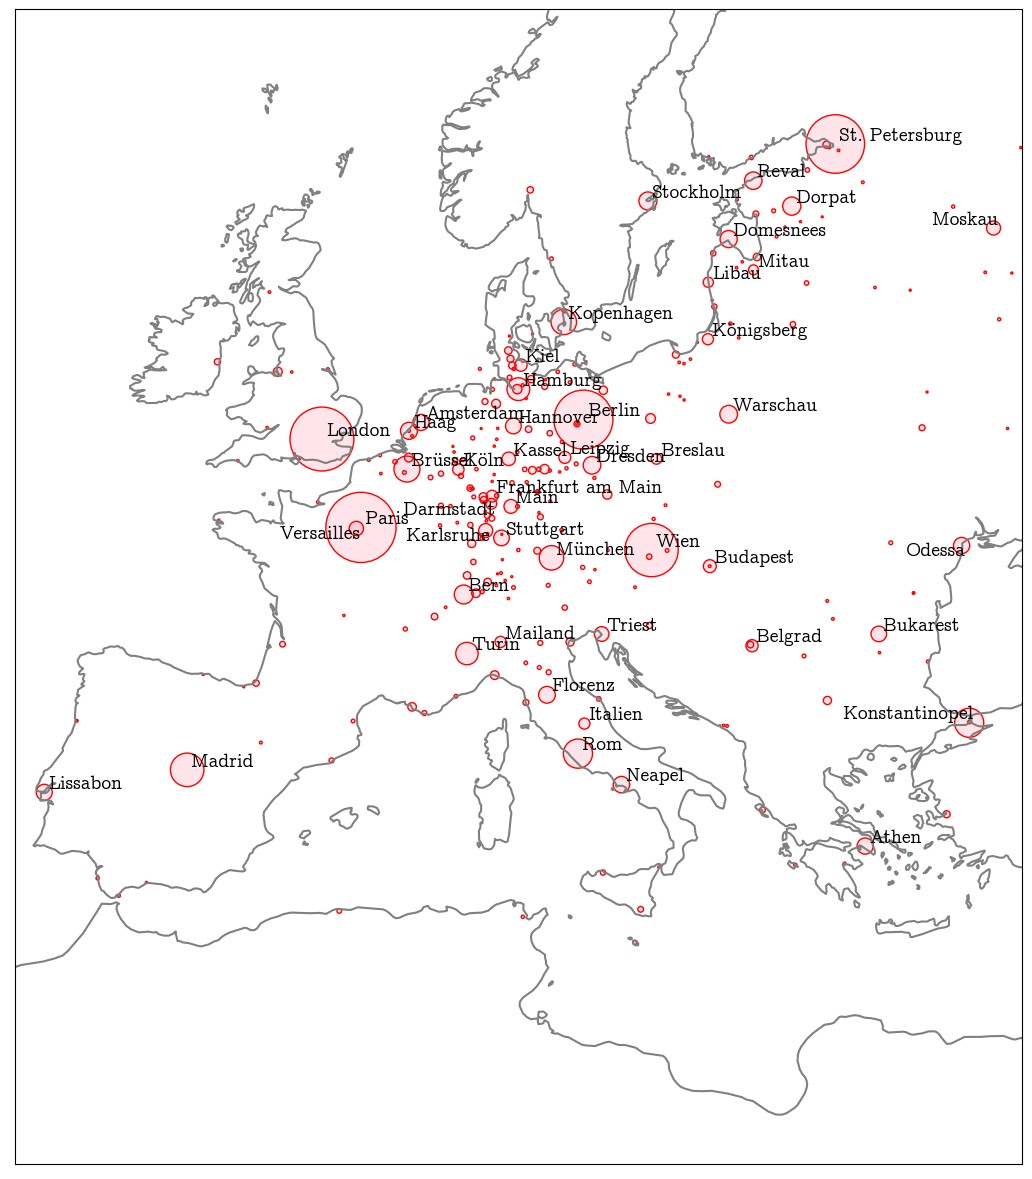

In [133]:
plot_europe(gdf_base, land, 500, savepath='../references/images/europe.png')

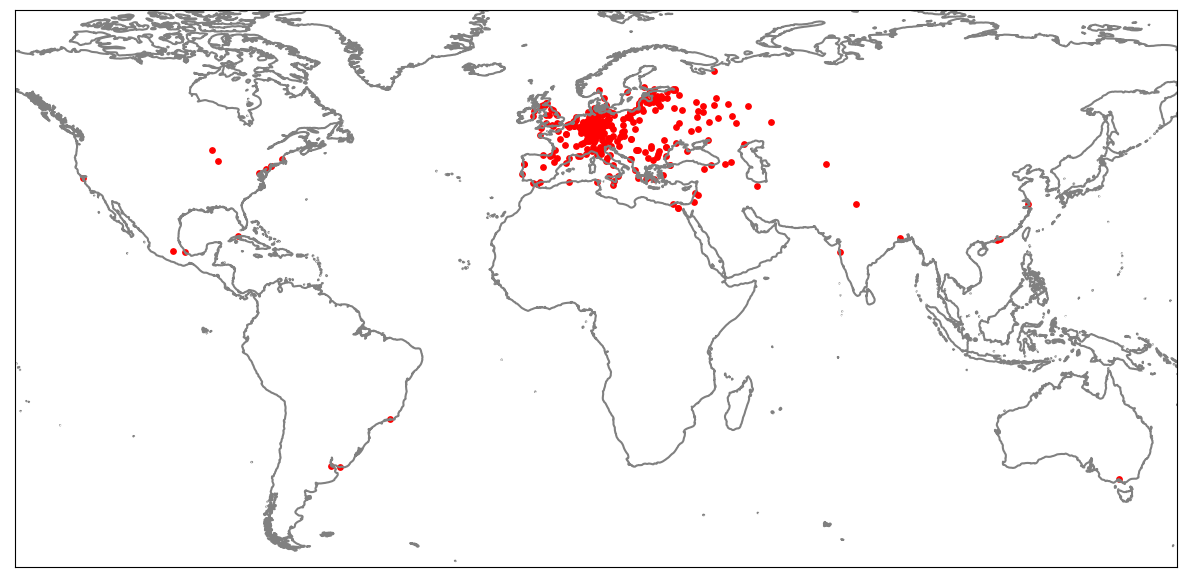

In [30]:
def plot_world(gdf, land, min_freq, savepath=None):
    
    plot_gdf = gdf.to_crs(crs='EPSG:4326')
    plot_land = gpd.read_file('../qgis/shapefiles/ne_50m_land.zip')
    
    fig, ax = plt.subplots(figsize=(15,10))
    
    plot_land.boundary.plot(ax=ax, color='grey') 
    plot_gdf.plot(ax=ax, markersize=15, color='red')


    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.set_xlim(-140, 160)
    ax.set_ylim(-60, 80)

    plt.xticks([])
    plt.yticks([])
    
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
        
    plt.show()
    
    
plot_world(gdf_base, land, 1000)
           #savepath='../references/images/world.png')

## Distance vs time plots

In [70]:
from adjustText import adjust_text

In [128]:
def plot_distance_and_time(timerange, min_freq, df=gdf_base, delta=delta, labels=[], savepath=None, log=False):
    
    if 'distance_to_riga' not in df.columns:
        riga = df.loc[df.placename=='Riga', 'geometry'].values[0]
        df.drop(df[df.placename == 'Riga'].index, inplace=True)
        df['distance_to_riga'] = np.round(df.geometry.distance(riga)/1000).astype(int)
    
    means = delta.loc[timerange[0]:timerange[-1]].mean().dropna()
    df['delta'] = df['placename'].apply(lambda x: means[x] if x in means.index else pd.NA)
    df.dropna(subset='delta', inplace=True)
    df.drop(df[df.placename == 'Riga'].index, inplace=True)
    
    #for name in df.sort_values(by='delta', ascending=False).placename.values[:10]:
    #    labels.append(name)
        
    fig, ax = plt.subplots(figsize=(15,5))

    ax.scatter(x=df['distance_to_riga'], y=df['delta'])
    ax.grid()
    plt.xticks(size=14)
    plt.yticks(size=14)
    
    if log:
        ax.set_xscale('log')
    else:
        x.set_xlim(-1000, 19000)

    ax.set_ylim(-10, 100)

    plt.xlabel('distance (km)', size=16)
    plt.ylabel('days', size=16)
    
    texts = []
    
    for name, x, y, freq in zip(df.placename, df.distance_to_riga, df.delta, df.total_freq):
        if freq >= min_freq or name in labels:
            #ax.annotate(name, (x, y), fontsize=14)
            texts.append(plt.text(x, y, name, fontsize=14))
            
    adjust_text(texts)
            
    plt.title(f'Distance and speed of news to Riga, {timerange[0]}-{timerange[-1]}', fontsize=18)
            
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
                
    plt.show()

In [129]:
custom_labels = list(gdf_base.sort_values(by='distance_to_riga', ascending=False).placename.values[:10])

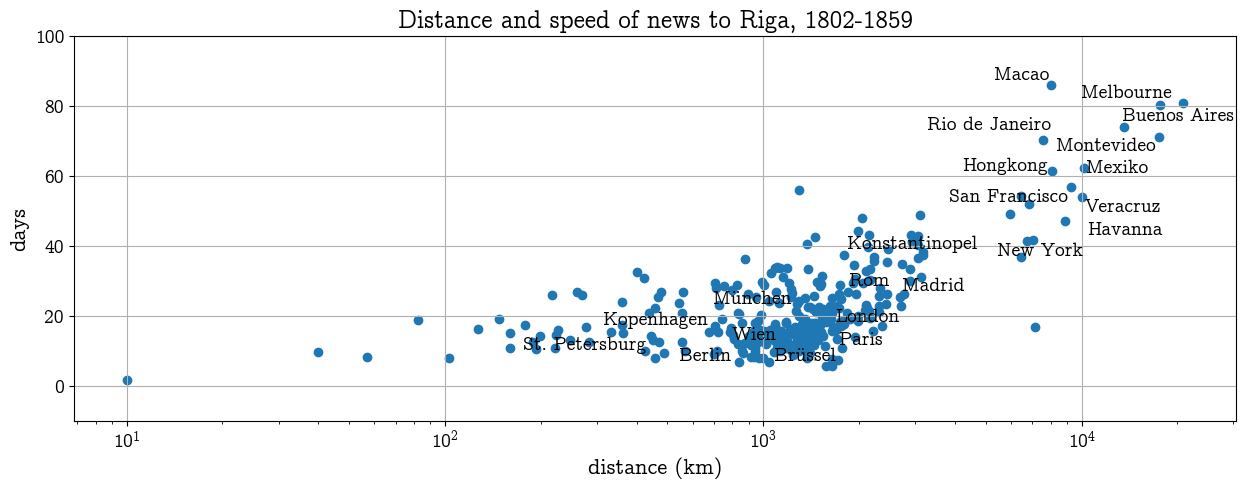

In [130]:
plot_distance_and_time(range(1802, 1860), 3000, gdf_base, delta, labels=custom_labels, log=True)
                      #savepath='../references/images/dist_speed_early.png')

In [131]:
custom_labels2 = list(delta.loc[1860:1889].mean().sort_values(ascending=False)[lambda x: x > 15].index)

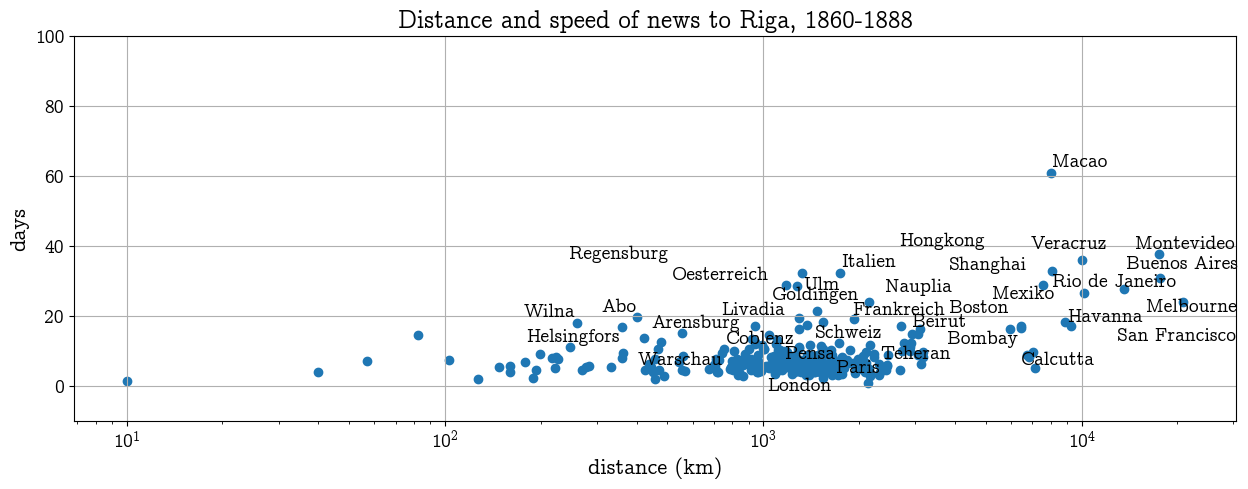

In [132]:
plot_distance_and_time(range(1860, 1889), 20000, gdf_base, delta, labels=custom_labels2, log=True)
                      #savepath='../references/images/dist_speed_late.png')

In [146]:
delta.loc[1802:1869, 'St. Petersburg'].mean()

8.559209596033135

In [246]:
stp = df.loc[(df.placename == 'St. Petersburg')].delta

In [252]:
round(len(stp)/86*10)

2393

In [256]:
stp.rolling(round(len(stp)/86*10), min_periods=1).quantile(0.25)

C:\Users\krister\AppData\Local\Temp\ipykernel_26944\1829813841.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  stp.rolling(round(len(stp)/86*10), min_periods=1).quantile(0.25)[11666:11700]


170187    1.0
170205    1.0
170213    1.0
170225    1.0
170226    1.0
170240    1.0
170242    1.0
170255    1.0
170267    1.0
170271    1.0
170278    1.0
170286    1.0
170291    1.0
170301    1.0
170304    1.0
170310    1.0
170314    1.0
170335    1.0
170341    1.0
170353    1.0
170356    1.0
170359    1.0
170374    1.0
170377    1.0
170383    1.0
170394    1.0
170397    1.0
170405    1.0
170408    1.0
170422    1.0
170442    1.0
170452    1.0
170454    1.0
170455    1.0
Name: delta, dtype: float64

In [175]:
def Remove_Outlier_Indices(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((series < (Q1 - 1.5 * IQR)) |(series > (Q3 + 1.5 * IQR)))
    return trueList

In [176]:
q1 = stp.quantile(0.25)
q3 = stp.quantile(0.75)
iqr = q3 - q1
print(q1, q3, iqr)

4.0 8.0 4.0


In [177]:
q3 + 1.5*iqr

14.0

In [234]:
def quartile_comparison(place, timerange, **kwargs):
    
    data = df.loc[(df.placename == place) & (df.doc_year.isin(timerange))].delta
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    filtr = ~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
    data_filtered = data.loc[filtr]
    
    print(f'Allowed values between {Q1 - 1.5 * IQR} - {Q3 + 1.5 * IQR}')

    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    
    data.hist(ax=axes[0], color='blue', **kwargs)
    plt.title(place)

    data_filtered.hist(ax=axes[1], color='orange', **kwargs)
    
    plt.show()
    
    print('\t', len(data), round(data.mean(), 2),
          '\t\t\t\t\t\t\t',
          len(data_filtered), round(data_filtered.mean(), 2),
          round(len(data_filtered)/len(data), 3))
    
    

Allowed values between -5.625 - 19.375


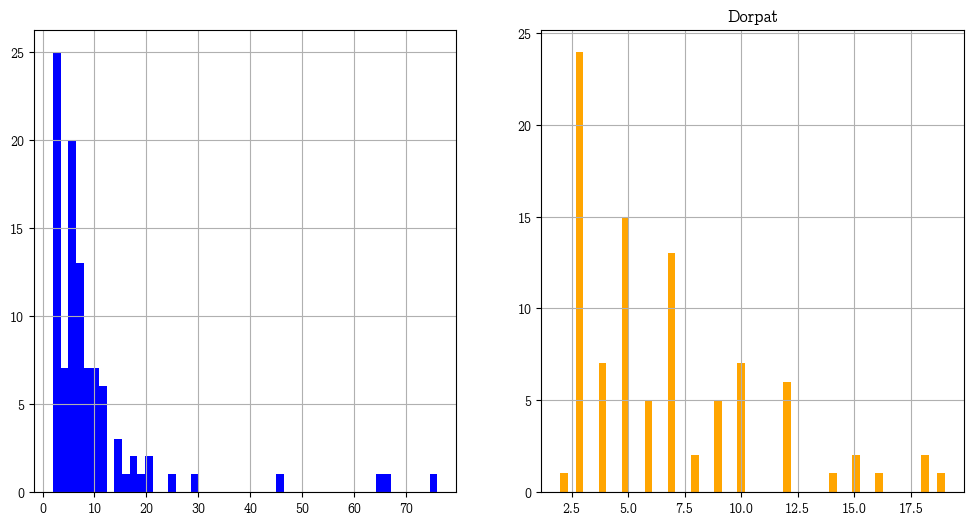

	 100 9.63 							 92 6.7 0.92


In [239]:
quartile_comparison('Dorpat', range(1802,1840), bins=50)